In [1]:
from collections import defaultdict
import pathlib
from pathlib import Path
import os
import sys
import argparse

import matplotlib.pyplot as plt
import numpy as np
# from sklearn.linear_model import LinearRegression
# import matplotlib.pyplot as plt
from tqdm.auto import tqdm
# from evaluate_pile_losses import evaluate_pile_losses
# from evaluate_pile_induction_criterias import evaluate_pile_induction_criterias

# import scipy.linalg
import torch
import torch.nn.functional as F
import sklearn.cluster

import datasets
from transformers import AutoTokenizer, GPTNeoXForCausalLM

In [2]:
cache_dir = "/om/user/ericjm/quanta-discovery/cache/"
pile_canonical = "/om/user/ericjm/the_pile/the_pile_test_canonical_200k"

In [3]:
model_name = "pythia-70m"
step = 143000
tokenizer = AutoTokenizer.from_pretrained(
    f"EleutherAI/{model_name}",
    revision=f"step{step}",
    cache_dir=os.path.join(cache_dir, model_name, f"step{step}"),
)

# ----- load the_pile test set -----
dataset = datasets.load_from_disk(pile_canonical)

def tokenize_sample(sample):
    tokens = tokenizer(sample["text"], return_tensors='pt', 
                        max_length=1024, truncation=True)["input_ids"]
    return {"input_ids": tokens}

starting_indexes = np.array([0] + list(np.cumsum(dataset["preds_len"])))

def loss_idx_to_dataset_idx(idx):
    """given an idx in range(0, 10658635), return
    a sample index in range(0, 20000) and pred-in-sample
    index in range(0, 1023). Note token-in-sample idx is
    exactly pred-in-sample + 1"""
    sample_index = np.searchsorted(starting_indexes, idx, side="right") - 1
    pred_in_sample_index = idx - starting_indexes[sample_index]
    return int(sample_index), int(pred_in_sample_index)

def get_context(idx):
    """given idx in range(0, 10658635), return dataset sample
    and predicted token index within sample, in range(1, 1024)."""
    sample_index, pred_index = loss_idx_to_dataset_idx(idx)
    return dataset[sample_index], pred_index+1

def print_context(idx):
    """
    given idx in range(0, 10658635), print prompt preceding the corresponding
    prediction, and highlight the predicted token.
    """
    sample, token_idx = get_context(idx)
    prompt = sample["split_by_token"][:token_idx]
    prompt = "".join(prompt)
    token = sample["split_by_token"][token_idx]
    print(prompt + "\033[41m" + token + "\033[0m")

/om2/user/ericjm/miniconda3/envs/phase-changes/lib/python3.8/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


In [9]:
token_idxs, C = torch.load("../results/paper-replication/pythia-70m-v0_143000_0.14426950408889636_50_10000_v1.pt")
cluster_tokens, cluster_labels = torch.load("../results/paper-replication/400_auto_pythia-70m-v0_143000_0.14426950408889636_50_10000_v1.pt")

In [10]:
C.shape

torch.Size([10000, 10000])

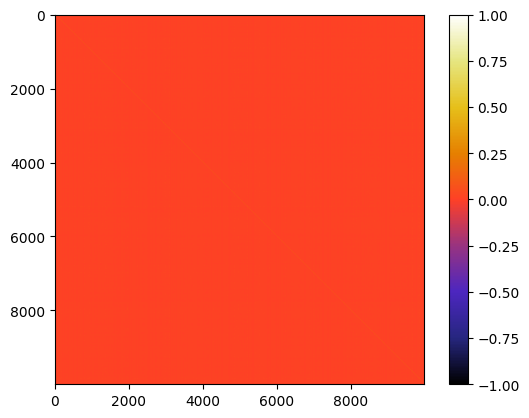

In [13]:
plt.imshow(C, cmap='CMRmap', vmin=-1, vmax=1)
plt.colorbar()

In [12]:
label_frequencies = defaultdict(int)
for l in cluster_labels:
    label_frequencies[l] += 1

labels_sorted_by_freq = sorted(label_frequencies.keys(), key=lambda k: label_frequencies[k], reverse=True)
# label_permutation = [labels_sorted_by_freq.index(i) for i in labels_sorted_by_freq]
permutation = []
indices = defaultdict(list)
for i, cls in enumerate(cluster_labels):
    indices[cls].append(i)
for cls in labels_sorted_by_freq:
    permutation.extend(indices[cls])

In [14]:
labels_sorted_by_freq[0]

277

In [32]:
len(indices[labels_sorted_by_freq[397]])

2

In [37]:
C_permuted = C[permutation, :][:, permutation]

(8000.0, 7000.0)

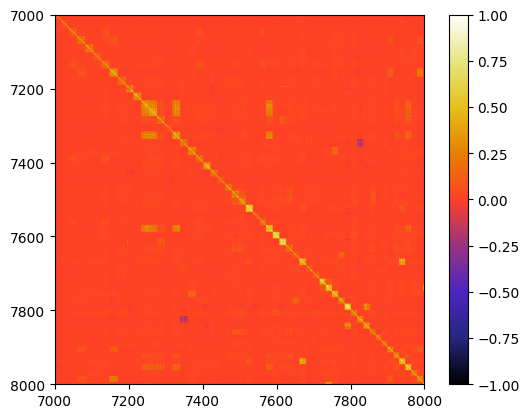

In [39]:
plt.imshow(C_permuted, cmap='CMRmap', vmin=-1, vmax=1)
plt.colorbar()
plt.xlim(7000, 8000)
plt.ylim(8000, 7000)

In [42]:
# let's look at the distribution of within-cluster cosine similarities
cluster_mean_similarities = []
for cls in labels_sorted_by_freq:
    cls_indices = indices[cls]
    cluster_mean_similarities.append(C[cls_indices, :][:, cls_indices].mean().item())

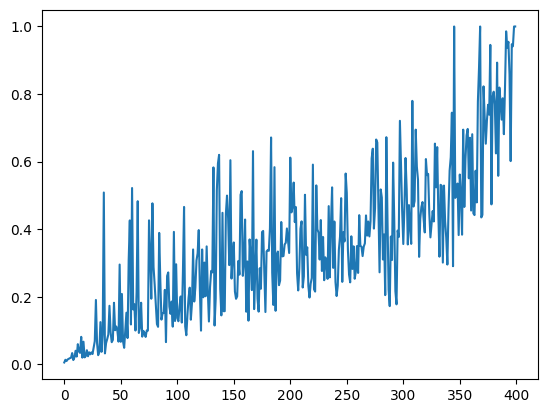

In [49]:
plt.plot(cluster_mean_similarities)

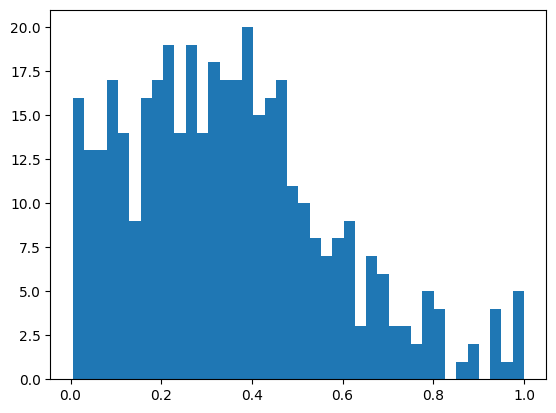

In [73]:
# plot distribution over similarities
_ = plt.hist(cluster_mean_similarities, bins=40)

In [60]:
# compute cross cluster similarities: mean cosine similarity between each element of cluster i and each element of cluster j
i = 326-1
j = 350-1
i_indices = indices[labels_sorted_by_freq[i]]
j_indices = indices[labels_sorted_by_freq[j]]
C[i_indices, :][:, j_indices].mean()

tensor(0.0549)

In [66]:
cross_mean_similarities = []
for i in tqdm(range(400)):
    for j in range(i+1, 400):
        i_indices = indices[labels_sorted_by_freq[i]]
        j_indices = indices[labels_sorted_by_freq[j]]
        cross_mean_similarities.append(((i, j), C[i_indices, :][:, j_indices].mean().item()))


  0%|          | 0/400 [00:00<?, ?it/s]

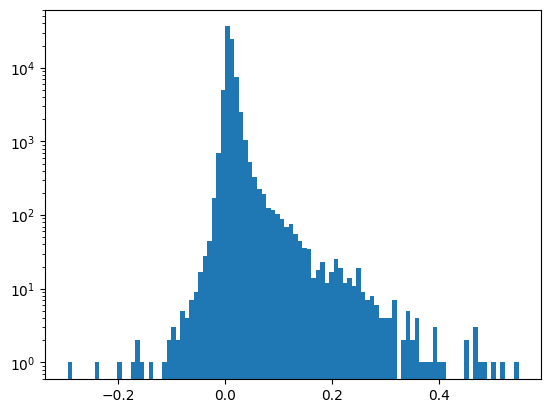

In [68]:
similarities = [s[1] for s in cross_mean_similarities]
_ = plt.hist(similarities, bins=100)
plt.yscale('log')

In [74]:
# find top-10 highest cross-similarity pairs
sorted_cross_mean_similarities = sorted(cross_mean_similarities, key=lambda x: x[1], reverse=True)
sorted_cross_mean_similarities[:50]

[((277, 285), 0.549086332321167),
 ((183, 285), 0.5194618105888367),
 ((249, 273), 0.5002146363258362),
 ((249, 357), 0.4826418459415436),
 ((186, 273), 0.4758187234401703),
 ((273, 357), 0.470431387424469),
 ((186, 357), 0.4665435552597046),
 ((186, 249), 0.4649750590324402),
 ((291, 361), 0.4508339464664459),
 ((135, 357), 0.45055362582206726),
 ((135, 249), 0.40639132261276245),
 ((140, 156), 0.397634893655777),
 ((183, 277), 0.39665287733078003),
 ((106, 132), 0.3948497176170349),
 ((334, 387), 0.39026662707328796),
 ((135, 186), 0.38558948040008545),
 ((135, 273), 0.3718465268611908),
 ((75, 167), 0.36419302225112915),
 ((106, 272), 0.36235180497169495),
 ((140, 201), 0.36205774545669556),
 ((75, 135), 0.3600214719772339),
 ((156, 201), 0.35621562600135803),
 ((75, 357), 0.35085806250572205),
 ((35, 49), 0.3485291302204132),
 ((286, 312), 0.345316082239151),
 ((75, 249), 0.34430399537086487),
 ((144, 160), 0.34406113624572754),
 ((76, 156), 0.341610848903656),
 ((119, 312), 0.3390